# Name to Language Classification using RNNs


## Load required libs, name-to-language data and util funcs

In [2]:
import os
import glob
import time
import math
import string
import random
import unicodedata
from io import open as io_open

import torch
import torch.nn as nn

In [3]:
# custom imports and load name-category data
from util import line_to_tensor, letter_to_tensor
from util import get_category_names_and_lines

random.seed(42)
torch.manual_seed(42)

ALL_LETTERS = string.ascii_letters + " .,;'" # character to consider
N_LETTERS = len(ALL_LETTERS)                 # length of one hot char encodiing vector

# Load name-to-category/language data
data_glob = "../data/names/*.txt"
category_names, category_lines = get_category_names_and_lines(data_glob)

N_CATEGORIES = len(category_names)

In [4]:
# Convert names into one-hot-encoded tensors
# one letter shape <1 x n_letters>
# one word shape <word_length x 1 x n_letters>

letter_to_tensor('a').shape, line_to_tensor('abc').shape

(torch.Size([1, 57]), torch.Size([3, 1, 57]))

## Create the RNN architecture

In [5]:
# instead of using our own custom RNN architecture, we use torch's LSTM
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, output_size)

    def forward(self, x, h):
        return self.lstm(x, h)
    
    def init_hidden(self):
        return torch.zeros([1, self.hidden_size])

In [30]:
# testing our simple RNN 
n_hidden = N_CATEGORIES
n_cell = 18
rnn = RNN(N_LETTERS, n_hidden, N_CATEGORIES)
cinput = letter_to_tensor('A').unsqueeze(1)
hidden = (torch.ones(1, 1, n_hidden),
          torch.ones(1, 1, n_cell))
output, next_hidden = rnn(cinput, hidden)

print(cinput.shape, output.shape, next_hidden[0].shape, next_hidden[1].shape)

torch.Size([1, 1, 57]) torch.Size([1, 1, 18]) torch.Size([1, 1, 18]) torch.Size([1, 1, 18])


In [31]:
# structure of our simple RNN
rnn

RNN(
  (lstm): LSTM(57, 18)
)

## Training

In [32]:
def get_category_from_output(output):
    category_i = torch.argmax(output)
    return category_names[category_i], category_i.item()

def get_random_training_example():
    category = random.choice(category_names)
    category_line = random.choice(category_lines[category])
    category_tensor = torch.tensor([category_names.index(category)], dtype=torch.long)
    category_line_tensor = line_to_tensor(category_line)
    return category, category_line, category_tensor, category_line_tensor

In [33]:
for i in range(10):
    category, line, category_tensor, line_tensor = get_random_training_example()
    print('category =', category, '/ line =', line)

category = Japanese / line = Araki
category = Irish / line = Dubhan
category = French / line = Denis
category = Japanese / line = Santo
category = Polish / line = Filipek
category = Portuguese / line = Araujo
category = Czech / line = Fritsch
category = Russian / line = Hlopkov
category = Korean / line = Sun
category = Czech / line = Koma


Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss

In [16]:
# loss criterion
criterion = nn.NLLLoss()

# learning rate
lr = 0.0056

# number of iterations
iterations = 100000

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, N_CATEGORIES)

In [17]:
def train_one_iter(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    # pass each char in line thorugh RNN
    for ctensor in line_tensor:
        output, hidden = rnn(ctensor, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    # this is done by an optimizer usually
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()


def get_time_since(start):
    now = time.time()
    s = now - start
    m = s / 60
    s = m - int(m)
    return f"{int(m)}m:{int(s*60)}s"

## training loop

In [18]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
start_time = time.time()
current_loss = 0
all_losses = []

for i in range(1, n_iters+1):
    category, category_line, category_tensor, category_line_tensor = get_random_training_example()
    pred_category_tensor, loss = train_one_iter(category_tensor, category_line_tensor)
    
    current_loss += loss
    if i % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

    if i % print_every == 0:
        pred_category, cat_idx = get_category_from_output(pred_category_tensor)
        correct = '✓' if pred_category == category else f"✗ ({category})"
        print(f"Iteration: {i} {i*100/(n_iters)}% Loss:{loss:.4f} {get_time_since(start_time)} {category_line} {pred_category} {correct}")

Iteration: 5000 5.0% Loss:2.3865 0m:4s Dickson Scottish ✓
Iteration: 10000 10.0% Loss:1.7395 0m:8s Kawazu Japanese ✓
Iteration: 15000 15.0% Loss:2.4373 0m:13s Degarmo Portuguese ✗ (French)
Iteration: 20000 20.0% Loss:0.8100 0m:17s Yin Chinese ✓
Iteration: 25000 25.0% Loss:2.2434 0m:21s Rios Greek ✗ (Portuguese)
Iteration: 30000 30.0% Loss:2.0983 0m:26s Alves Dutch ✗ (Portuguese)
Iteration: 35000 35.0% Loss:0.3869 0m:30s Macdonald Scottish ✓
Iteration: 40000 40.0% Loss:0.7063 0m:34s Lavoie French ✓
Iteration: 45000 45.0% Loss:1.8745 0m:39s Como Japanese ✗ (Italian)
Iteration: 50000 50.0% Loss:3.9995 0m:43s Desrosiers Portuguese ✗ (French)
Iteration: 55000 55.0% Loss:1.0403 0m:48s Oirschotten Dutch ✓
Iteration: 60000 60.0% Loss:2.7945 0m:52s Quinones Dutch ✗ (Spanish)
Iteration: 65000 65.0% Loss:1.4520 0m:56s Guerrero Portuguese ✗ (Spanish)
Iteration: 70000 70.0% Loss:0.1265 1m:1s Agnellutti Italian ✓
Iteration: 75000 75.0% Loss:0.8209 1m:5s Chan Chinese ✓
Iteration: 80000 80.0% Loss:1.7

## Plotting the results

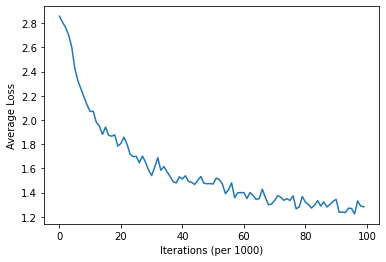

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xlabel(f"Iterations (per {plot_every})")
plt.ylabel(f"Average Loss")
plt.plot(all_losses)

## Evaluating results

/Users/samridha.shrestha/Main/projects/ml_recurrent_neural_networks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/samridha.shrestha/Main/projects/ml_recurrent_neural_networks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


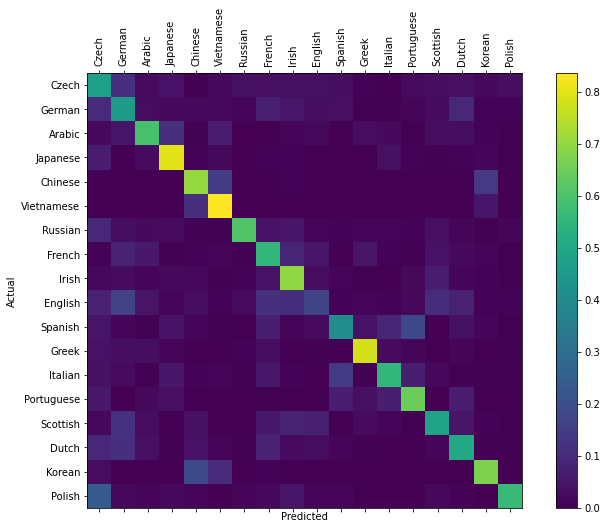

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(N_CATEGORIES, N_CATEGORIES)
n_confusion = 10000

# return an output tensor of size n_categories given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = get_random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = get_category_from_output(output)
    category_i = category_names.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(N_CATEGORIES):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + category_names, rotation=90)
ax.set_yticklabels([''] + category_names)

# Set axes labels
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [27]:
# evaluate on the whole dataset
correct, total = 0, 0
for cat_idx, category in enumerate(category_names):
    for line in category_lines[category]:
        line_tensor = line_to_tensor(line)
        output = evaluate(line_tensor)
        _, guess_i = get_category_from_output(output)
        correct += 1 if guess_i == cat_idx else 0
        total += 1
        
print(f"Accuracy: {100*correct/total:.2f}%")

Accuracy: 54.08%


## Inference on user input

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, category_names[category_index]))
            predictions.append([value, category_names[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.33) Russian
(-1.75) Czech
(-3.16) English

> Jackson
(-1.18) Scottish
(-1.19) English
(-2.17) Korean

> Satoshi
(-0.76) Japanese
(-1.88) Italian
(-2.75) Arabic
